In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import cmasher as cmr
from astropy.table import Table

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from gala.units import galactic
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

import pickle

In [2]:
mw = gp.MilkyWayPotential2022()

In [3]:
galcen_frame = coord.Galactocentric(
    galcen_distance=8.275 * u.kpc, galcen_v_sun=[8.4, 251, 8.4] * u.km / u.s
)


def get_w0_from_p(p, frame):
    # At phi1 = 0.
    orbit_w0_fr = coord.SkyCoord(
        phi1=0 * u.deg,
        phi2=p["phi2"] * u.deg,
        distance=p["distance"] * u.kpc,
        pm_phi1_cosphi2=p["pmphi1"] * u.mas / u.yr,
        pm_phi2=p["pmphi2"] * u.mas / u.yr,
        radial_velocity=p["rv"] * u.km / u.s,
        frame=frame,
    )
    orbit_w0_galcen = orbit_w0_fr.transform_to(galcen_frame)
    return gd.PhaseSpacePosition(orbit_w0_galcen.data)

## Stream orbits

In [70]:
torb = Table.read('../data/streams_full_summary.fits')
ind_finite = np.isfinite(torb['Lz'])
torb = torb[ind_finite]

In [71]:
torb

name,length,width,dhelio,dgal,ra_pole,dec_pole,ra0,dec0,alt_name,mstar,progenitor,ra,dec,distance,pmra,pmdec,Vr,rperi,rapo,T,ecc,Etot,L,Lx,Ly,Lz,Lperp,Lmax,circLz
,deg,deg,kpc,kpc,deg,deg,deg,deg,,solMass,,deg,deg,kpc,mas / yr,mas / yr,km / s,kpc,kpc,Myr,,kpc2 / Myr2,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,
bytes15,float64,float64,float64,float64,float64,float64,float64,float64,bytes10,float64,bytes16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
300S,11.084050035883632,0.4,15.929408712161088,20.580569319095165,308.05647015058037,72.50938813171143,157.51043124647902,15.343748423206394,Gaia-10,7600.0,dwarf galaxy,157.53075993872147,15.474858868958902,14.57002892031368,-3.5376922403116247,-3.0274054683274523,296.7913059624446,4.024076432922811,45.36313592772438,581.8348214285714,0.8370397420475069,-0.07983416150795594,1.96592248499056,0.8803084946114046,-1.7490616618896184,0.17518982337564037,1.9581010553025784,5.77977891209135,0.030310817427487004
ATLAS-Aliqa Uma,23.56167982001931,0.3,21.408035075347705,23.573578703777436,74.25906739590538,47.93312434806639,19.83735580474366,-27.70393545512226,--,19000.0,globular cluster,20.293258082767785,-27.07856857689201,20.650564588019005,-0.03466679532027617,-0.97900559173618,-107.03425492397811,12.405936500467133,38.08444476938491,565.78125,0.5085821818551108,-0.08185260758384007,4.121033995671389,3.6724387699918277,-0.44363869900736796,-1.8163973626063354,3.6991379826381228,5.523683188511237,0.32883807789416275
C-10,14.768667124010776,0.53,1.0000000000000004,8.627393761987229,55.688623430228965,5.743018048839959,145.87052300925814,1.8080538305484724,--,1800.0,--,145.99607492750735,1.795422392327991,8.205007955394423,-0.5676348780194557,0.7228817492607146,46.06907779862649,13.443955572655808,20.150307754194237,356.7307692307692,0.19962789826018928,-0.10043054691295619,3.5145777973294003,-1.4550749154134914,0.20870642161299263,-3.1924059443611963,1.469966455361509,3.7046949554578377,0.861718976256891
C-11,35.03272272625432,2.2,1.0000000000000002,9.040591292276861,346.2172321783179,24.733491853731937,106.66600286938663,47.728846494982285,--,1100.0,--,109.35115283113686,46.22115218969786,6.873541419416133,6.188170242374492,-1.5263686713034286,-44.904203730043065,12.431005240574999,19.63791407257823,339.8928571428571,0.22473188951669104,-0.1024609990942999,3.3596696275921567,-0.2313867972843105,2.6217899544192487,-2.0880750924030593,2.631980701876664,3.5530868655610837,0.5876791565784931
C-12,28.108716970589512,0.8,1.0,8.672220194603375,108.93910628132723,59.60464435638812,96.4532835417892,-29.800392178039857,--,14000.0,--,96.4506291478248,-29.821318329939928,11.068698495457802,-0.6403795801949531,-1.4510933847201861,294.68030267511915,6.151906515587104,19.690869235829346,276.11764705882354,0.5238973882091659,-0.11054803413547225,2.2380316305110632,1.2650617083867826,-1.6976194934268865,-0.7255980351948071,2.1171426665412616,3.0193584358031615,0.24031530228102752
C-13,23.228234770181842,0.6,1.0000000000000002,8.871176349234375,129.10002268017254,5.106115518452886,34.236165476807045,43.49779785186792,--,750.0,--,35.66478825356473,38.58877319158014,8.198159879891218,3.340748638379775,1.8461084620868702,-102.6346125995457,13.767308022905114,16.074304512133974,313.68333333333334,0.07730803710825132,-0.10595573865776986,3.260407316629894,1.1585371402141647,2.2439769125976556,-2.0621869897773157,2.525399114897865,3.309388177963606,0.6231323975558101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spectre,7.5552076408692095,0.46,12.499999999999998,14.226473081037561,269.76,-33.55,217.57945953070083,42.75810118682118,--,--,dwarf galaxy,217.6630683578526,42.687803587249384,14.168823491441117,-5.717704114575444,-4.938511772090894,-144.17460290593002,15.637380229835935,33.33016276208874,540.4444444444445,0.361

## Globular cluster orbits

In [7]:
tgc = Table.read('../data/gc_best.fits')

In [8]:
c_gc = coord.SkyCoord(ra=tgc['RAdeg'], dec=tgc['DEdeg'], distance=tgc['Dist'], pm_ra_cosdec=tgc['pmRA'],
                     pm_dec=tgc['pmDE'], radial_velocity=tgc['HRV'], frame='icrs')

In [9]:
w0_gc = gd.PhaseSpacePosition(c_gc.transform_to(galcen_frame).data)

In [10]:
w0_gc

<PhaseSpacePosition cartesian, dim=3, shape=(149,)>

In [11]:
dt = 0.5*u.Myr
T = 5*u.Gyr
Nstep = int((T/dt).decompose())
gc_orbit = mw.integrate_orbit(w0_gc, dt=dt, n_steps=Nstep)

In [12]:
l_gc = gc_orbit.angular_momentum()[:,0,:]
np.shape(l_gc)

(3, 149)

In [25]:
# store GC orbital parameters
tgc['rperi'] = gc_orbit.pericenter()
tgc['rapo'] = gc_orbit.apocenter()
tgc['ecc'] = gc_orbit.eccentricity()
tgc['Etot'] = gc_orbit.energy()[0,:]

l_gc = gc_orbit.angular_momentum()[:,0,:]
tgc['lx'] = l_gc[0,:]
tgc['ly'] = l_gc[1,:]
tgc['Lz'] = l_gc[2,:]
tgc['lperp'] = np.sqrt(tgc['lx']**2 + tgc['ly']**2)

In [26]:
tgc

Name,OName,RAdeg,DEdeg,Dist,HRV,e_HRV,pmRA,pmDE,e_pmRA,e_pmDE,corr,Rscale,Nstar,plx,e_plx,plx_adpt,e_plx_adpt,rperi,rapo,ecc,etot,lx,ly,lz,lperp,Etot,Lz
,,deg,deg,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,,arcmin,,mas,mas,mas,mas,kpc,kpc,,kpc2 / Myr2,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr2,kpc2 / Myr
bytes11,bytes10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC 104,47 Tuc,6.024,-72.081,4.5,-17.21,0.18,5.252,-2.551,0.021,0.021,-0.002,18.3,23917,0.232,0.009,0.232,0.009,6.248821120339059,7.593326572656797,0.09713127486698175,-0.1425597822161687,0.4250741951145736,0.56581372372314,-1.325314454764523,0.7076957264995659,-0.1425597822161687,-1.325314454764523
NGC 288,,13.188,-26.583,8.9,-44.83,0.13,4.164,-5.705,0.024,0.024,0.019,6.1,2544,0.141,0.011,0.141,0.011,2.38353471720624,12.241979841522527,0.6740580021803466,-0.13545955997285566,-0.4224747059699436,0.5072958045741478,0.4014770446667243,0.6601771811589084,-0.13545955997285566,0.4014770446667243
NGC 362,,15.809,-70.849,8.6,223.26,0.28,6.694,-2.535,0.025,0.024,-0.004,7.8,1741,0.114,0.011,0.114,0.011,0.9555987618092274,12.039554589452084,0.8529299753563159,-0.13830305722091607,-0.23950798346681001,0.21571916508351252,0.023744407581082982,0.32233341795207254,-0.13830305722091607,0.023744407581082982
Whiting 1,,30.738,-3.253,30.1,-130.41,1.79,-0.228,-2.046,0.065,0.056,-0.050,0.5,11,0.017,0.047,0.0332,0.005,21.468337778458384,67.29632332529461,0.516286379928494,-0.0604989108470632,0.7864919264345408,-6.616058037178802,-1.8478300173947515,6.662641630889728,-0.0604989108470632,-1.8478300173947515
NGC 1261,,48.068,-55.216,16.3,71.36,0.24,1.596,-2.064,0.025,0.025,0.009,4.1,541,0.068,0.011,0.0613,0.0092,1.4648162846106687,21.225622052135467,0.8708869116698846,-0.11255036152352321,0.04762218447479161,-0.41873038039146704,0.29574639970041816,0.42142971408875973,-0.11255036152352321,0.29574639970041816
Pal 1,,53.334,79.581,11.1,-75.41,0.21,-0.252,0.007,0.034,0.037,0.003,0.7,51,0.112,0.023,0.0901,0.0135,15.390120290498478,19.88169730159776,0.12734180764491598,-0.09840431657964725,-0.9624141424620226,-0.1368275253731267,-3.652638468471821,0.9720919469425946,-0.09840431657964725,-3.652638468471821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NGC 7078,M 15,322.493,12.167,10.4,-106.76,0.25,-0.659,-3.803,0.024,0.024,0.001,9.9,2198,0.097,0.01,0.097,0.01,3.994695051093186,10.538630961973515,0.4502710463521407,-0.1385961513886483,0.044958981340162935,-0.6051538802367817,-1.1060039366694683,0.6068216614202053,-0.1385961513886483,-1.1060039366694683


## Dwarf galaxy orbits

In [27]:
tdg1 = Table.read('../data/positions_classical.fits')
tdg2 = Table.read('../data/positions_ufd.fits')
tdg = at.vstack([tdg1, tdg2])

In [28]:
tdg

name,ra,dec,distance,pmra,pmdec,vr
,deg,deg,kpc,mas / yr,mas / yr,km / s
bytes13,float64,float64,float64,float64,float64,float64
Fornax,40.00780743363775,-34.435256294558926,147.63830803690482,0.3769404681705849,-0.41272411712930246,55.60331941726113
Draco,260.01917166918696,57.894514085062596,76.33485442443708,-0.01862293618139517,-0.1440486405705083,-291.03494291708455
Carina,100.3916830273474,-50.957559166890746,104.94508087566562,0.49225625597294176,0.14052976866958242,222.97062239365852
UrsaMinor,227.26963402454277,67.18920978619778,76.03012560820875,-0.18325880590353155,0.07293981502345305,-246.4930821839468
Sextans,153.27397118790606,-1.6215553096665782,86.06956488794398,-0.4975674744097807,0.0774405806688931,224.34434315009185
LeoI,152.117771737837,12.296845635575927,253.98505861565945,-0.09537710675007108,-0.08840518129503885,280.49169659150823
...,...,...,...,...,...,...
ComaBerenices,186.7458,23.9076,42.0,0.546,-1.726,98.1


In [29]:
c_dg = coord.SkyCoord(ra=tdg['ra'], dec=tdg['dec'], distance=tdg['distance'], pm_ra_cosdec=tdg['pmra'],
                     pm_dec=tdg['pmdec'], radial_velocity=tdg['vr'], frame='icrs')

In [30]:
w0_dg = gd.PhaseSpacePosition(c_dg.transform_to(galcen_frame).data)

In [31]:
dg_orbit = mw.integrate_orbit(w0_dg, dt=dt, n_steps=Nstep)

In [32]:
# store GC orbital parameters
tdg['rperi'] = dg_orbit.pericenter()
tdg['rapo'] = dg_orbit.apocenter()
tdg['ecc'] = dg_orbit.eccentricity()
tdg['Etot'] = dg_orbit.energy()[0,:]

l_dg = dg_orbit.angular_momentum()[:,0,:]
tdg['lx'] = l_dg[0,:]
tdg['ly'] = l_dg[1,:]
tdg['Lz'] = l_dg[2,:]
tdg['lperp'] = np.sqrt(tdg['lx']**2 + tdg['ly']**2)

In [33]:
tdg

name,ra,dec,distance,pmra,pmdec,vr,rperi,rapo,ecc,Etot,lx,ly,Lz,lperp
,deg,deg,kpc,mas / yr,mas / yr,km / s,kpc,kpc,,kpc2 / Myr2,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr
bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Fornax,40.00780743363775,-34.435256294558926,147.63830803690482,0.3769404681705849,-0.41272411712930246,55.60331941726113,124.60504518308583,194.82865721904278,0.2198378302222909,-0.026761049524295713,-23.024479913660134,-2.2338938892762004,7.995582493411188,23.132595124695467
Draco,260.01917166918696,57.894514085062596,76.33485442443708,-0.01862293618139517,-0.1440486405705083,-291.03494291708455,34.893662146886314,93.66942927731141,0.457174500700926,-0.048700162099432676,-9.715493305875984,1.3172154566334282,-2.8252646838841495,9.804379977118138
Carina,100.3916830273474,-50.957559166890746,104.94508087566562,0.49225625597294176,0.14052976866958242,222.97062239365852,104.38668432648225,112.13447328455757,0.03578305715505874,-0.03514434737686295,-17.57418849314613,5.816737774685363,-2.9264027309032277,18.511794605928447
UrsaMinor,227.26963402454277,67.18920978619778,76.03012560820875,-0.18325880590353155,0.07293981502345305,-246.4930821839468,39.72251884289459,90.44253440361155,0.38965923875637776,-0.04850912679779855,-10.264537206953307,-3.5370837973952445,-0.7818461377780762,10.856872747836954
Sextans,153.27397118790606,-1.6215553096665782,86.06956488794398,-0.4975674744097807,0.0774405806688931,224.34434315009185,nan,420.2015639649595,nan,-0.018863241657396182,-8.819992943389328,-12.263986553350883,-17.609942059761465,15.106212023608327
LeoI,152.117771737837,12.296845635575927,253.98505861565945,-0.09537710675007108,-0.08840518129503885,280.49169659150823,nan,nan,nan,-0.006078014909445935,-16.501473196834517,-17.715020136030724,-21.5964064603438,24.20992680876632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ComaBerenices,186.7458,23.9076,42.0,0.546,-1.726,98.1,42.87710418173742,135.35807594718582,0.5188704704568085,-0.03938796114929491,-0.4014415634924284,12.586602252993492,1.141924105547951,12.59300248566481


## Phase space figure

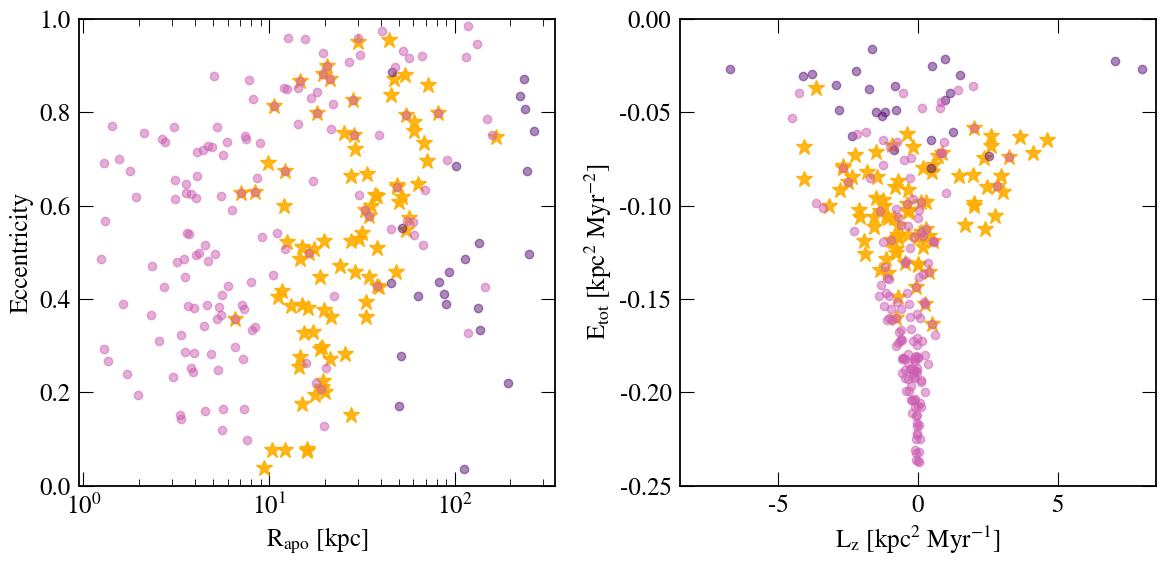

In [72]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

purple = '#5a1179'
orange = '#ffae00'
magenta = '#cd5eb3'

# s = (torb['nstar']*4)**0.5

plt.sca(ax[0])
plt.plot(torb['rapo'], torb['ecc'], '*', color=orange, alpha=0.9, ms=12)
plt.plot(tdg['rapo'], tdg['ecc'], 'o', color=purple, alpha=0.5, ms=6)
plt.plot(tgc['rapo'], tgc['ecc'], 'o', color=magenta, alpha=0.5, ms=6)

plt.ylim(0,1)
plt.gca().set_xscale('log')
plt.xlabel('$R_{apo}$ [kpc]')
plt.ylabel('Eccentricity')

plt.sca(ax[1])
plt.plot(torb['Lz'], torb['Etot'], '*', color=orange, alpha=0.9, ms=12)
plt.plot(tdg['Lz'], tdg['Etot'], 'o', color=purple, alpha=0.5, ms=6)
plt.plot(tgc['Lz'], tgc['Etot'], 'o', color=magenta, alpha=0.5, ms=6)

plt.xlim(-8.5,8.5)
plt.ylim(-0.25,0)
plt.xlabel('$L_z$ [kpc$^2$ Myr$^{-1}$]')
plt.ylabel('$E_{tot}$ [kpc$^2$ Myr$^{-2}$]')

plt.tight_layout()

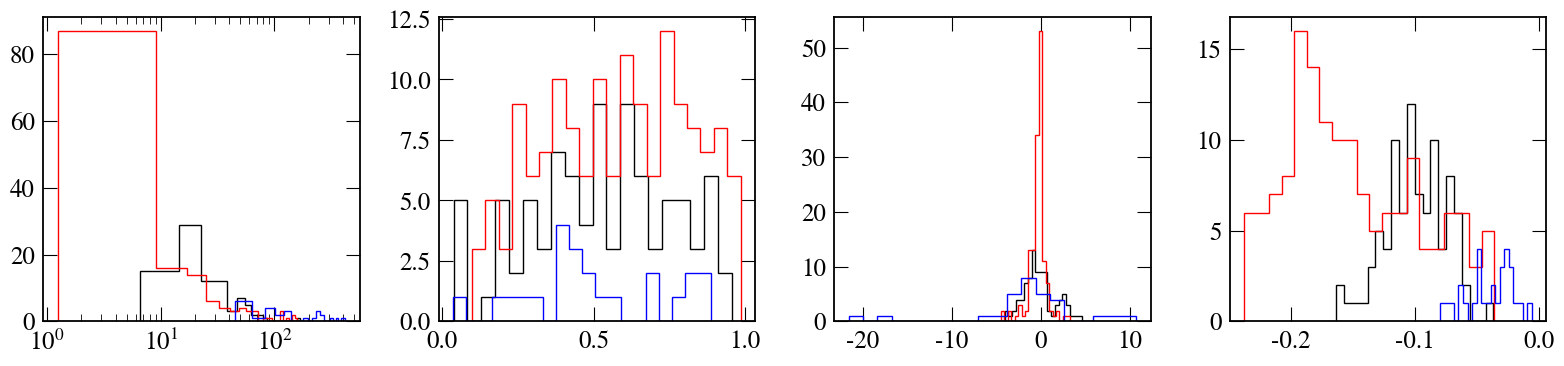

In [73]:
fig, ax = plt.subplots(1,4,figsize=(16,4))

ind_bound = (torb['Etot']<0)
Nbin = 20

for i, k in enumerate(['rapo', 'ecc', 'Lz', 'Etot']):
    plt.sca(ax[i])
    ind_finite = np.isfinite(torb[k])
    plt.hist(torb[k][ind_bound & ind_finite], bins=Nbin, color='k', histtype='step')
    plt.hist(tgc[k], bins=Nbin, color='r', histtype='step')
    plt.hist(tdg[k], bins=Nbin, color='b', histtype='step')
#     plt.axvline(np.median(torb[k][ind_bound & ind_finite]), color='r')
    
ax[0].set_xscale('log')
plt.tight_layout()

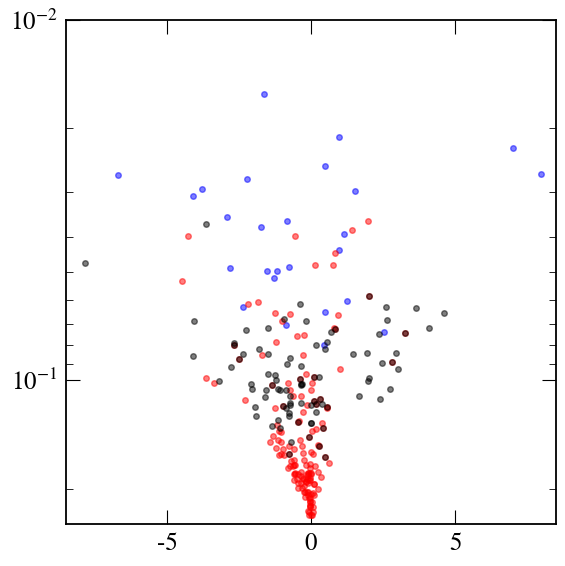

In [74]:
plt.figure(figsize=(6,6))
plt.plot(tdg['Lz'], np.abs(tdg['Etot']), 'bo', alpha=0.5, ms=4)
plt.plot(tgc['Lz'], np.abs(tgc['Etot']), 'ro', alpha=0.5, ms=4)
plt.plot(torb['Lz'], np.abs(torb['Etot']), 'ko', alpha=0.5, ms=4)
plt.gca().set_yscale('log')
plt.gca().invert_yaxis()
plt.xlim(-8.5,8.5)
plt.ylim(0.25,0.01)

plt.tight_layout()

### Figure with histograms

In [75]:
purple = '#5a1179'
orange = '#ffae00'
magenta = '#cd5eb3'

labels = ['Streams', 'Dwarf galaxies', 'Globular clusters']
tables = [torb, tdg, tgc]
colors = [orange, purple, magenta]
colors = [orange, '#3935d8', '#6de3ef']
icolors = [orange, 'none', 'none']
symbols = ['*', 'o', 'o']
sizes = [12, 6, 6]
sizes = [10, 4, 4]
alphas = [0.8, 0.5, 0.5]
mew = [1,2,2]
# histtypes = ['stepfilled', 'step', 'step']
histtypes = ['step', 'stepfilled', 'stepfilled']
alphas_hist = [0.9, 0.3, 0.3]


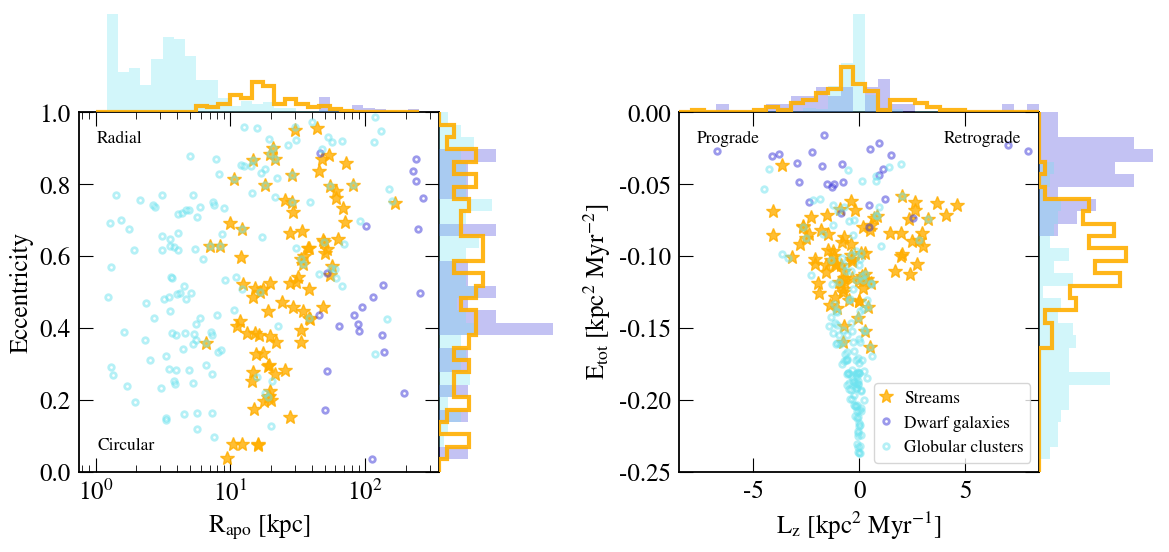

In [76]:
fig = plt.figure(figsize=(12,6))
gs1 = fig.add_gridspec(nrows=2, ncols=2, left=0.05, right=0.45, wspace=0.0, hspace=0, width_ratios=[3,1],
                      height_ratios=[1,3.5])
ax2 = fig.add_subplot(gs1[1,0])
ax0 = fig.add_subplot(gs1[0,0], sharex=ax2)
ax1 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[1,1], sharey=ax2)

gs2 = fig.add_gridspec(nrows=2, ncols=2, left=0.55, right=0.95, wspace=0.0, hspace=0, width_ratios=[3,1],
                      height_ratios=[1,3.5])
ax6 = fig.add_subplot(gs2[1,0])
ax4 = fig.add_subplot(gs2[0,0], sharex=ax6)
ax5 = fig.add_subplot(gs2[0,1])
ax7 = fig.add_subplot(gs2[1,1], sharey=ax6)

for ax in [ax1, ax5, ax0, ax3, ax4, ax7]:
    plt.sca(ax)
    plt.axis('off')

#############
# Rapo - ecc

plt.sca(ax2)
for i, t in enumerate(tables):
    plt.plot(t['rapo'], t['ecc'], symbols[i], color=icolors[i], mec=colors[i], mew=mew[i], alpha=alphas[i], ms=sizes[i])

plt.text(0.05,0.05,'Circular', fontsize='x-small', transform=plt.gca().transAxes, va='bottom')
plt.text(0.05,0.95,'Radial', fontsize='x-small', transform=plt.gca().transAxes, va='top')
    
plt.ylim(0,1)
plt.gca().set_xscale('log')
plt.xlabel('$R_{apo}$ [kpc]')
plt.ylabel('Eccentricity')

# Histograms
plt.sca(ax0)
bins_rapo = np.logspace(0,2.4,30)
# bins_rapo = np.linspace(0,300,30)
for i, t in enumerate(tables):
    plt.hist(t['rapo'], bins=bins_rapo, color=colors[i], histtype=histtypes[i], lw=3, alpha=alphas_hist[i],
             density=True)
    
plt.sca(ax3)
bins_ecc = np.linspace(0,1,30)
for i, t in enumerate(tables):
    plt.hist(t['ecc'], bins=bins_ecc, color=colors[i], histtype=histtypes[i], lw=3, alpha=alphas_hist[i],
             density=True, orientation='horizontal')

#########
# E - Lz

plt.sca(ax6)
for i, t in enumerate(tables):
    plt.plot(t['Lz'], t['Etot'], symbols[i], color=icolors[i], mec=colors[i], mew=mew[i], alpha=alphas[i], ms=sizes[i],
            label=labels[i])

plt.text(0.05,0.95,'Prograde', fontsize='x-small', transform=plt.gca().transAxes, va='top')
plt.text(0.95,0.95,'Retrograde', fontsize='x-small', transform=plt.gca().transAxes, va='top', ha='right')
plt.legend(loc=4, handlelength=0.5, fontsize='x-small')

plt.xlim(-8.5,8.5)
plt.ylim(-0.25,0)
plt.xlabel('$L_z$ [kpc$^2$ Myr$^{-1}$]')
plt.ylabel('$E_{tot}$ [kpc$^2$ Myr$^{-2}$]')

# Histograms
plt.sca(ax4)
bins_lz = np.linspace(-8.5,8.5,30)
for i, t in enumerate(tables):
    plt.hist(t['Lz'], bins=bins_lz, color=colors[i], histtype=histtypes[i], lw=3, alpha=alphas_hist[i], density=True)
    
plt.sca(ax7)
bins_etot = np.linspace(-0.25,0,30)
for i, t in enumerate(tables):
    plt.hist(t['Etot'], bins=bins_etot, color=colors[i], histtype=histtypes[i], lw=3, alpha=alphas_hist[i], 
             density=True, orientation='horizontal')

# plt.tight_layout()
plt.savefig('../tex/figures/orbital_phase_space.pdf')

### Orbital stats

In [77]:
ind_finite = np.isfinite(torb['rapo'])

In [78]:
np.percentile(torb['rapo'][ind_finite], [5,50,85,95])

/usr/local/lib64/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


10.088093887493681
24.127954547014422
50.0802409277889
66.58383329130757


In [79]:
np.percentile(torb['rperi'][ind_finite], [5,25,50,95])

1.1449806730138872
4.749117030681477
8.677678772102679
15.697647762502616


In [80]:
np.percentile(torb['Lz'][ind_finite], [5,16,50,57,84,95])

-2.743205622114304
-1.7978972847417576
-0.36338323276685547
-0.06624730109435535
2.0027264059515146
2.9988262925089937


In [81]:
np.percentile(tgc['Lz'], [5,16,50,84,95])

-2.0524812748783194
-1.0030729127375946
-0.16850495532378748
0.16753042121185646
0.8329286777544391


### Orbital pole distribution

In [82]:
theta = np.arcsin(torb['Lz']/torb['L'])
phi = np.arctan2(torb['Ly'], torb['Lx'])

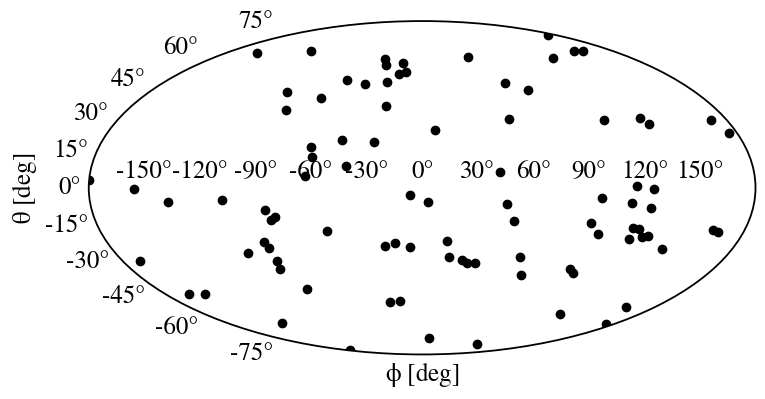

In [83]:
fig = plt.figure()
fig.add_subplot(projection='mollweide')
plt.plot(phi, theta, 'ko')

plt.xlabel('$\phi$ [deg]')
plt.ylabel('$\\theta$ [deg]')

plt.tight_layout()

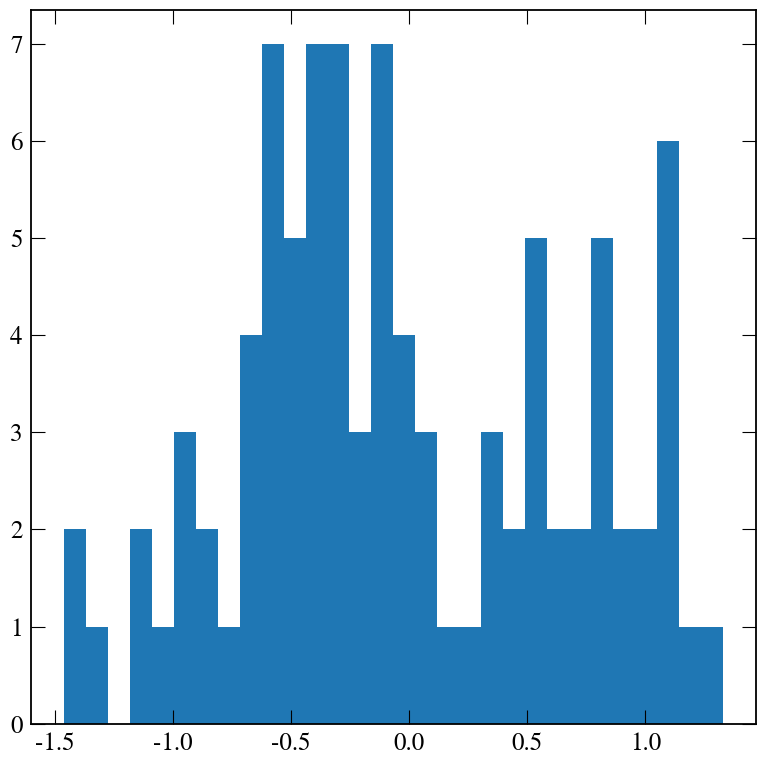

In [85]:
plt.hist(theta, bins=30)

plt.tight_layout()